# Fetal immune atlas - BBKNN Integration

In this notebook we perform integration of datasets from different organs

In [64]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
from bbknn import bbknn
import scipy

## For geosketch integration
from geosketch import gs, uniform, srs, kmeanspp
from scanorama import transform
from scipy.sparse import csr_matrix, find
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
# from subprocess import Popen
# import sys
from time import time
from datetime import datetime

### Load merged dataset 

In [2]:
merged_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
merged_raw.obs['batch'] = [x+y for x,y in zip(merged_raw.obs['organ'],merged_raw.obs['method'])]
merged_raw.obs['bbk'] = [x+y for x,y in zip(merged_raw.obs['donor'],merged_raw.obs['method'])]

Change barcodes for gut cells

In [2]:
def _rename_gut_cells(x):
    if "FCA" not in x:
        x = x.split("_")[8].split('-')[1] + "-1"  + "_" + "_".join(x.split("_")[3:6])
    else: 
        x = x.split("_")[7].split('-')[1] + "-1" + "_" + "_".join(x.split("_")[3:5]) 
    return(x)

In [23]:
obs_names[gut_ixs]

array(['AAACCTGAGACCCACC-1_Human_colon_16S7985393',
       'AAACCTGAGGCAGGTT-1_Human_colon_16S7985393',
       'AAACCTGAGTAGGTGC-1_Human_colon_16S7985393', ...,
       'TTTGTCAGTCCTCTTG-1_Human_colon_16S7985391',
       'TTTGTCAGTTTCGCTC-1_Human_colon_16S7985391',
       'TTTGTCATCTCCAGGG-1_Human_colon_16S7985391'], dtype=object)

In [ ]:
obs_names = merged_raw.obs_names.values
gut_ixs = np.where(merged_raw.obs.organ=="GU")[0]
for i in gut_ixs:
    obs_names[i] = _rename_gut_cells(obs_names[i])

In [6]:
merged_raw.obs_names = obs_names

### Add obs with uniform labels and correct metadata

Made uniform in `notebooks/20210112_saveLabels.ipynb`

In [74]:
new_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv", index_col=0)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
merged_raw.obs = new_obs

NameError: name 'merged_raw' is not defined

In [4]:
## Load cell cycle genes
cwd = '/nfs/team205/ed6/data/Fetal_immune/Pan_fetal/JP_archive/18_Pan_fetal/scjp'
sys.path.append(cwd)

In [6]:
from scjp.genes import cc_genes

In [7]:

def remove_geneset(adata,geneset):
    adata = adata[:,~adata.var_names.isin(list(geneset))].copy()
    return adata

# def get_subset(idata, select, cc_genes=cc_genes, log=False,raw=True):
#     if raw:
#         adata = sc.AnnData(idata[select].raw.X)
#         adata.var = idata.raw.var
#     else:
#         adata = sc.AnnData(idata[select].X)
#         adata.var = idata.var
#     adata.obs = idata.obs[select]
#     adata.raw = adata.copy()
#     #adata.X = scipy.sparse.csr_matrix(np.exp(adata.X.todense())-1)
#     sc.pp.filter_genes_dispersion(adata,log=log)
#     if log:
#         sc.pp.log1p(adata)
#     sc.pp.scale(adata,max_value=10)
#     if len(cc_genes)>0:
#         print('removing cc_genes...')
#         adata = remove_geneset(adata,cc_genes)
#     sc.pp.pca(adata,n_comps = np.min([50,adata.X.shape[0],adata.X.shape[1]]))
#     return adata

def is_cycling(adata,cc_genes=cc_genes,cut_off=0.4):
    X = np.mean(adata.X[:,adata.var_names.isin(cc_genes)],axis=1)
    plt.hist(X)
    adata.obs['Cycle_score'] = X
    adata.obs['isCycle'] = X>cut_off

def preprocess4sketch(sdata, how="pd"):
    sc.pp.filter_genes_dispersion(sdata)
    sc.pp.scale(sdata,max_value=10)
    sdata = remove_geneset(sdata,cc_genes)
    if "p" in how:
        sc.pp.pca(sdata)
    if "d" in how:
        sc.pp.neighbors(sdata)
        sc.tl.diffmap(sdata)
    return sdata

# def get_sketch_single(sdata,folds=10,how='pd',min_num_per_key=500):
#     '''
#     geometric sketching based on diffusion map and pca
#     - folds: folds to subsample
#     - min_num_per_key: minimun number to sample
#     '''
#     c = sdata.shape[0]
#     print('from:',c)

#     N = np.max([np.int(c/folds),np.min([min_num_per_key,c])])
#     print('to select:',N)
#     if how =='pd':
#         set1 = set(sdata.obs_names[gs(sdata.obsm['X_diffmap'],N,replace=False)])
#         set2 = set(sdata.obs_names[gs(sdata.obsm['X_pca'][:,:50],N,replace=False)])
#         sketch_index = list(set1.union(set2))
#     elif how =='p':
#         set2 = set(sdata.obs_names[gs(sdata.obsm['X_pca'][:,:50],N,replace=False)])
#         sketch_index = list(set2)
#     elif how =='d':
#         set1 = set(sdata.obs_names[gs(sdata.obsm['X_diffmap'][:,:20],N,replace=False)])
#         sketch_index = list(set1)
#     else:
#         raise SystemError
#     print('length of sketch:',len(sketch_index))
#     return(sketch_index)

### Correction of technical effects

Using ridge regression to regress out technical covariates (especially `method`) while conserving info on labels from expert annotation.

In [122]:
import scipy
from sklearn.linear_model import Ridge

def ridge_regression(adata,batch_key,confounder_key=[], chunksize=1e8):
	'''
	batch regression tool
	batch_key=list of observation categories to be regressed out
	confounder_key=list of observation categories to be kept
	chunksize=how many elements of X to process at once, will iterate over genes
	corrects X in the adata and adds .uns['X_explained']
	'''
	
	dummy = pd.get_dummies(adata.obs[batch_key+confounder_key],drop_first=False)
	if len(batch_key)>1:
		batch_index = np.logical_or.reduce(np.vstack([dummy.columns.str.startswith(x) for x in batch_key]))
	else:
		batch_index = np.vstack([dummy.columns.str.startswith(x) for x in batch_key])[0]
	dm = np.array(dummy)[:,batch_index]
	
	LR = Ridge(fit_intercept=False, alpha=1.0)
	chunkcount = np.ceil(chunksize/adata.shape[0])
	X_explained = []
	X_remain = []
	for ind in np.arange(0,adata.shape[1],chunkcount):
		X_exp = adata.X[:,np.int(ind):np.int(ind+chunkcount)] # scaled data
		if scipy.sparse.issparse(X_exp):
			X_exp = X_exp.todense()
		LR.fit(dummy,X_exp)	
		X_explained.append(dm.dot(LR.coef_[:,batch_index].T))
		X_remain.append(X_exp - X_explained[-1])
	
	X_explained = np.hstack(X_explained)
	X_remain = np.hstack(X_remain)
	adata.X = X_remain
	adata.layers['X_explained'] = X_explained


In [58]:
## Preprocess full dataset
merged_pp = preprocess4sketch(merged_raw, how="p")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [130]:
merged_pp.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.preprocessed.h5ad')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  for key in string_cols:


In [120]:
merged_pp = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.preprocessed.h5ad')

In [ ]:
start=datetime.now()
ndata, X_explained = ridge_regression(merged_pp, batch_key=['method','donor'],confounder_key=['uniform_label'])
v2_time = datetime.now()-start
print("Ridge V2 runtime: ", str(v2_time))

In [31]:
sc.pp.pca(ndata)

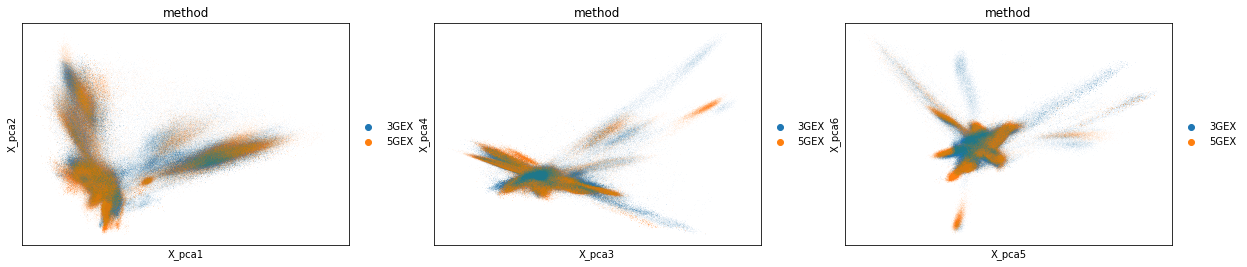

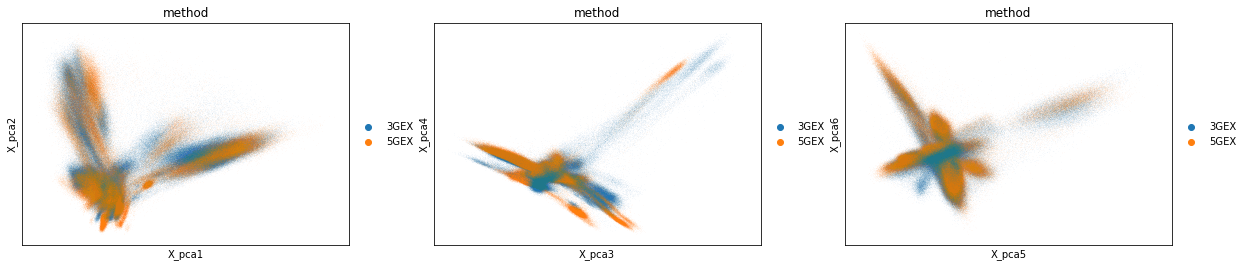

In [34]:
## Check results
sc.pl.embedding(merged_pp, "X_pca", color="method", components=["1,2", '3,4', '5,6'])
sc.pl.embedding(ndata, "X_pca", color="method", components=["1,2", '3,4', '5,6'])
# sc.pl.embedding(merged_pp, "X_pca_old", color="method", components=["1,2", '3,4', '5,6'])

In [43]:
merged_pp.obsm["X_pca_corrected"] = ndata.obsm["X_pca"]

In [45]:
merged_pp.obsm["X_pca"] = merged_pp.obsm["X_pca_corrected"]

In [46]:
today = datetime.now().date().strftime('%Y%m%d')
merged_pp.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_{}.h5ad'.format(today))

In [47]:
merged_pp

AnnData object with n_obs × n_vars = 913795 × 3195
    obs: 'uniform_label', 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'sort', 'method', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk', 'in_sketch', 'in_sketch_nn'
    var: 'GeneName', 'GeneID', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'method_colors', 'neighbors', 'organ_colors', 'pca', 'umap', 'uniform_label_colors'
    obsm: 'X_pca', 'X_pca_old', 'X_umap', 'X_pca_corrected'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Integration with BBKNN

In [48]:
## Full dataset
start=datetime.now()
bbknn(merged_pp, batch_key = "bbk", n_pcs=30, approx=True)
bbknn_time = datetime.now()-start
print("BBKNN runtime: ", str(bbknn_time))

start=datetime.now()
sc.tl.umap(merged_pp)
umap_time = datetime.now()-start
print("UMAP runtime: ", str(umap_time))

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


BBKNN runtime:  0:15:22.474364
UMAP runtime:  0:45:44.819092


In [81]:
merged_pp

AnnData object with n_obs × n_vars = 913795 × 3195
    obs: 'uniform_label', 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'sort', 'method', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk'
    var: 'GeneName', 'GeneID', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca', 'method_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_old', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [49]:
today = datetime.now().date().strftime('%Y%m%d')
merged_pp.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_{}.h5ad'.format(today))

In [78]:
## Here I am adding the labels post-hoc (waiting for full annotations) ##
merged_pp.obs = new_obs

### Visualize results

... storing 'Sample' as categorical
... storing 'donor' as categorical
... storing 'organ' as categorical
... storing 'method' as categorical
... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'batch' as categorical
... storing 'bbk' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical


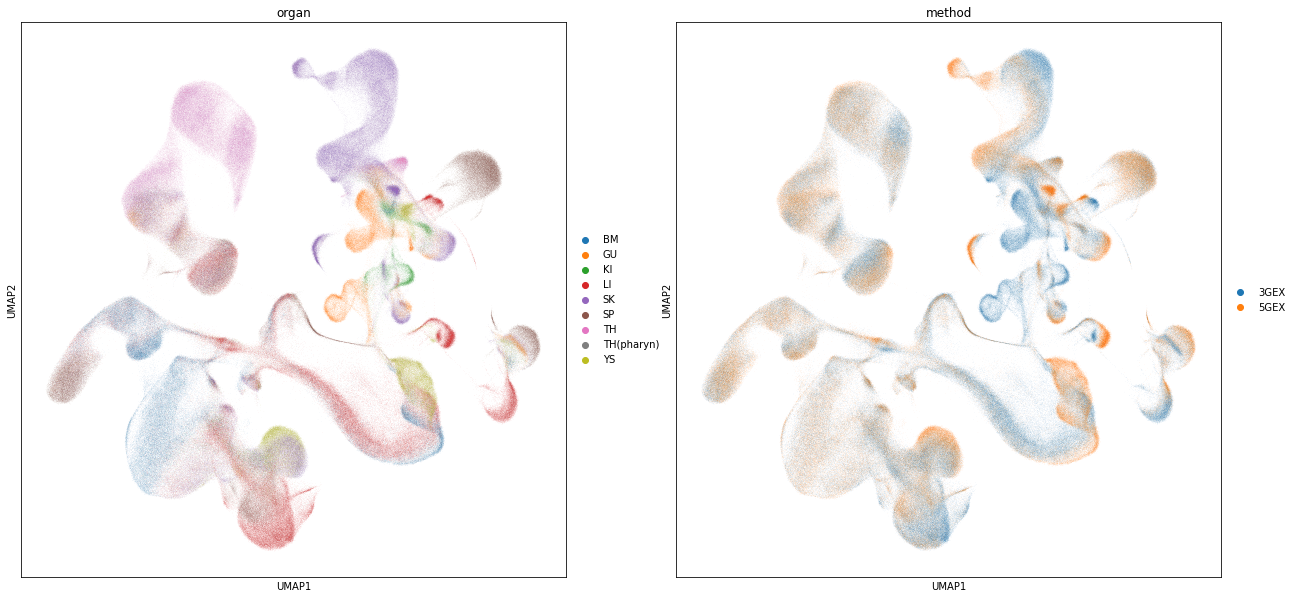

In [79]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_pp, color=["organ", "method"])

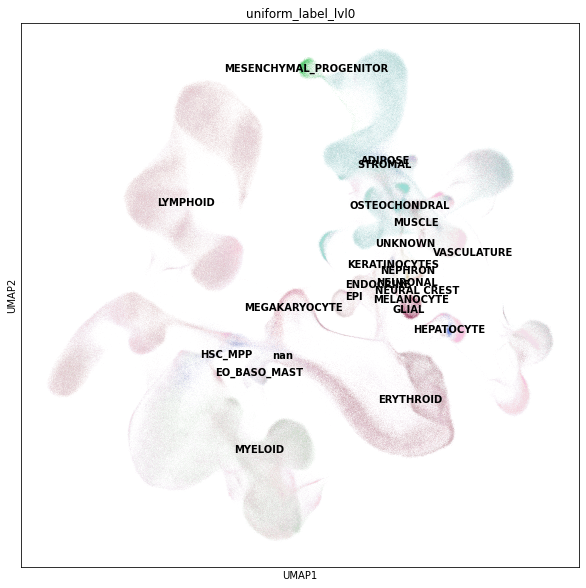

In [82]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_pp, color=["uniform_label_lvl0"], legend_loc="on data")

Trying to set attribute `.uns` of view, copying.


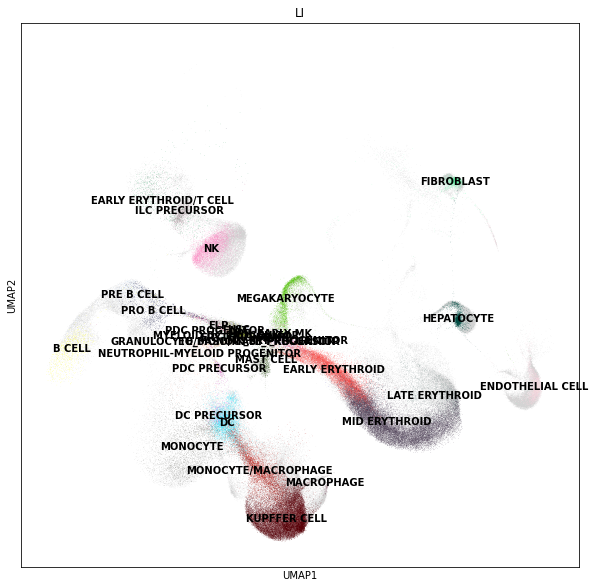

Trying to set attribute `.uns` of view, copying.


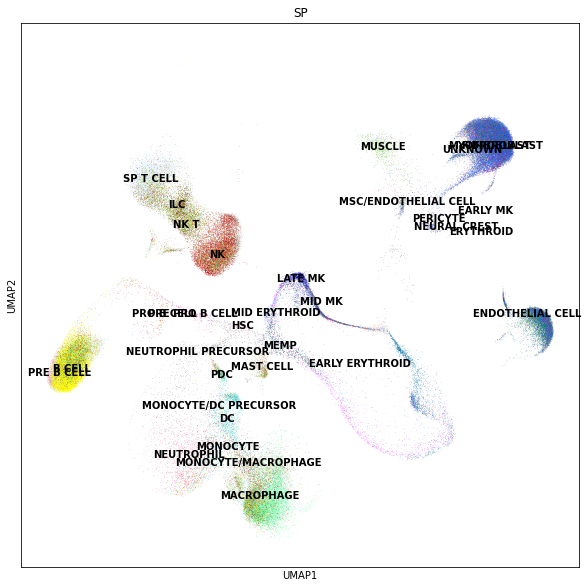

Trying to set attribute `.uns` of view, copying.


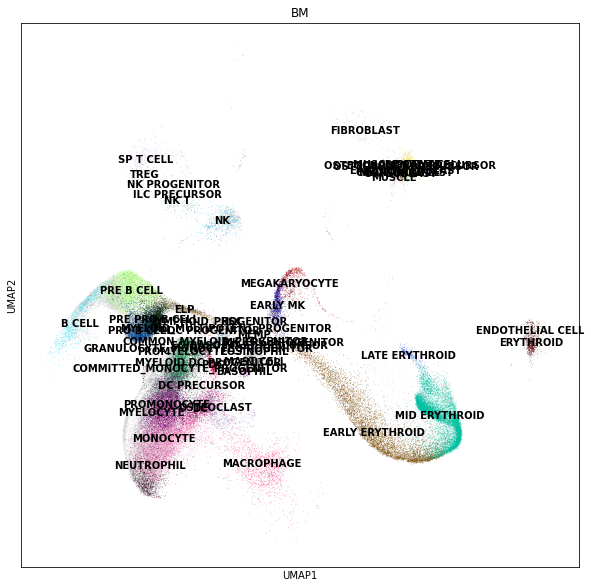

Trying to set attribute `.uns` of view, copying.


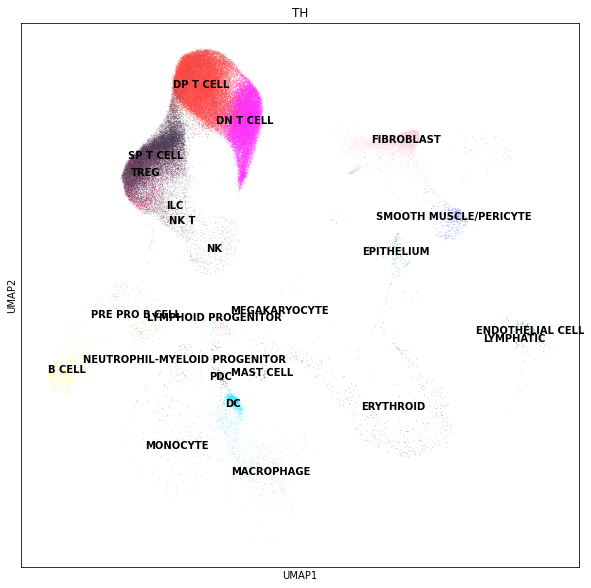

Trying to set attribute `.uns` of view, copying.


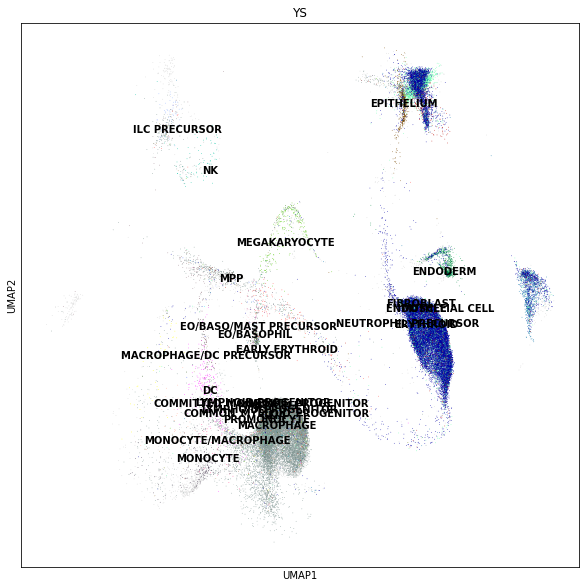

Trying to set attribute `.uns` of view, copying.


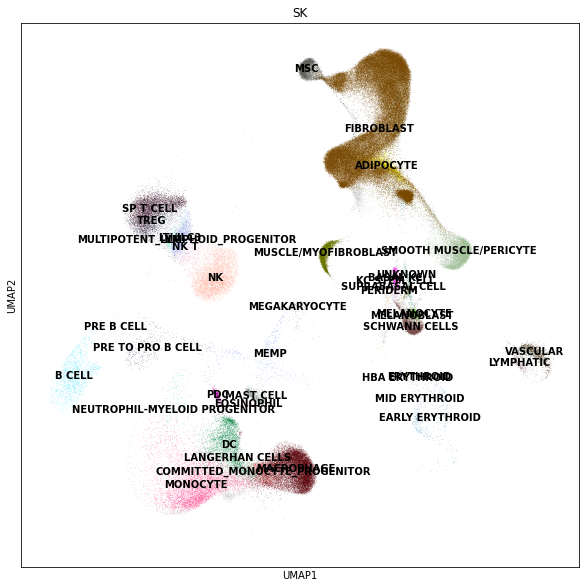

Trying to set attribute `.uns` of view, copying.


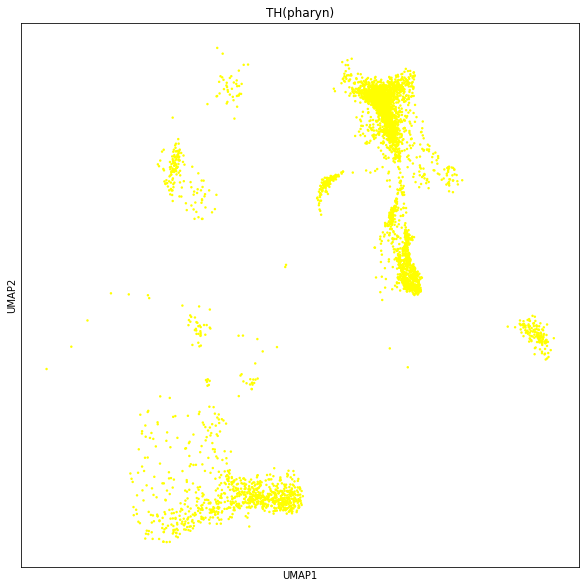

Trying to set attribute `.uns` of view, copying.


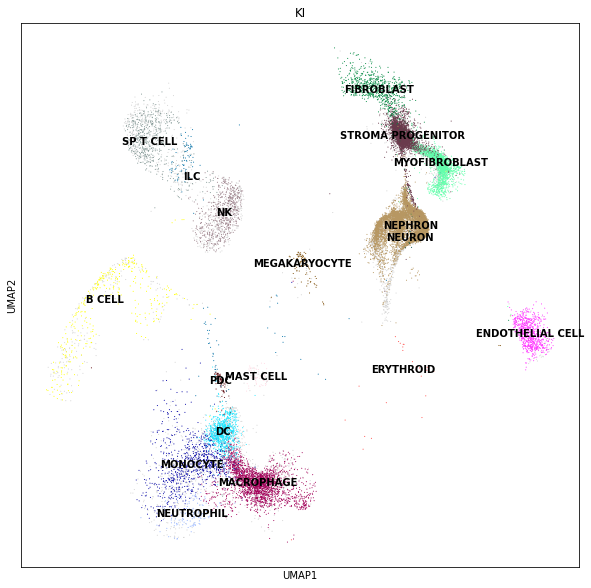

Trying to set attribute `.uns` of view, copying.


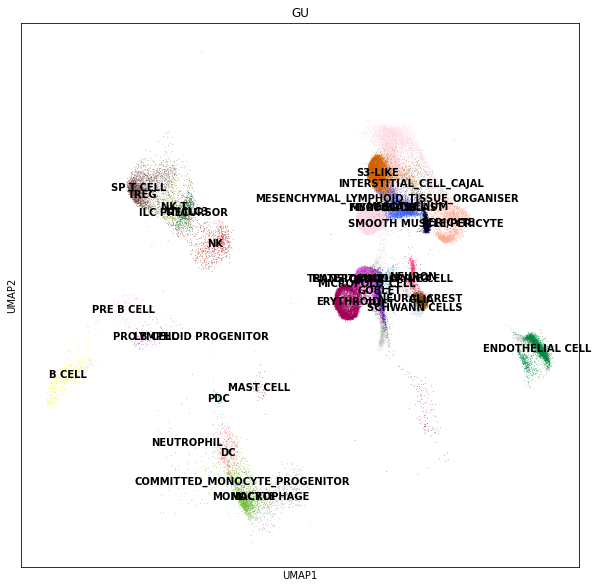

In [84]:
i=1
for org in merged_pp.obs['organ'].unique():
    subset_organ_adata = merged_pp[merged_pp.obs['organ']==org]
    sc.pl.umap(subset_organ_adata, color="uniform_label_expanded_merged", palette=sc.plotting.palettes.default_102,
               legend_loc="on data",
               groups=subset_organ_adata[subset_organ_adata.obs["uniform_label_expanded_merged"] != "nan"].obs["uniform_label_expanded_merged"].unique(),
               title=org
              )
    i += 1

Plot by broad cell types

Trying to set attribute `.uns` of view, copying.


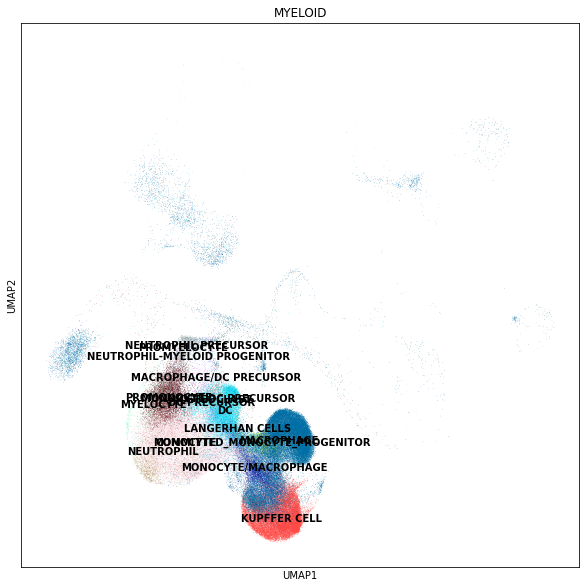

Trying to set attribute `.uns` of view, copying.


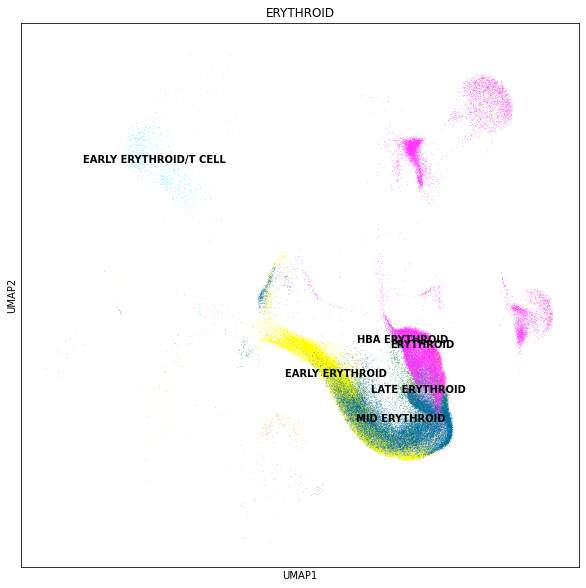

Trying to set attribute `.uns` of view, copying.


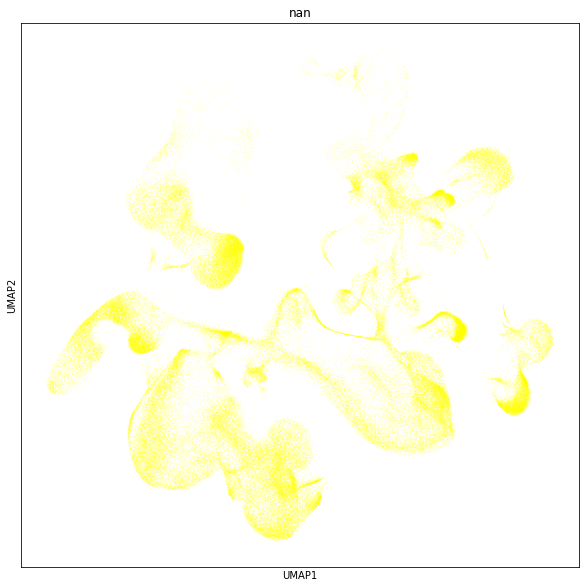

Trying to set attribute `.uns` of view, copying.


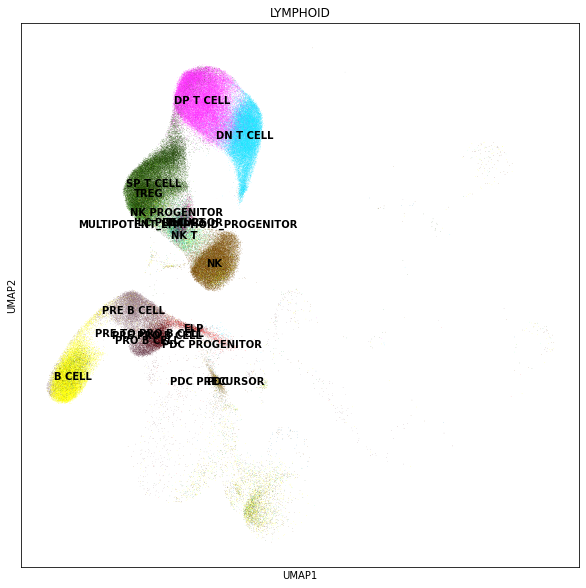

Trying to set attribute `.uns` of view, copying.


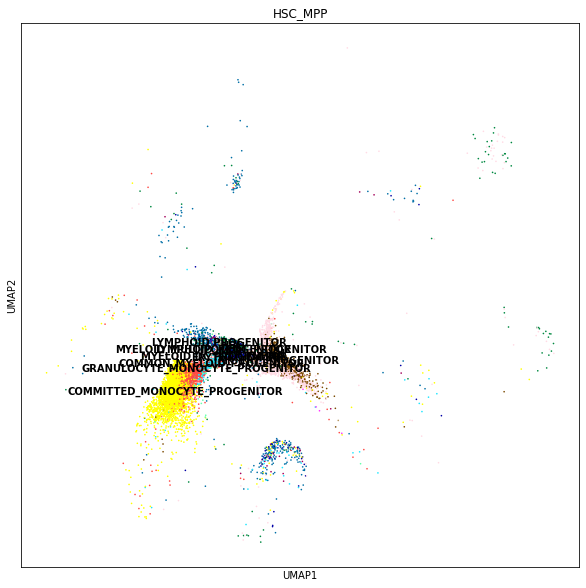

Trying to set attribute `.uns` of view, copying.


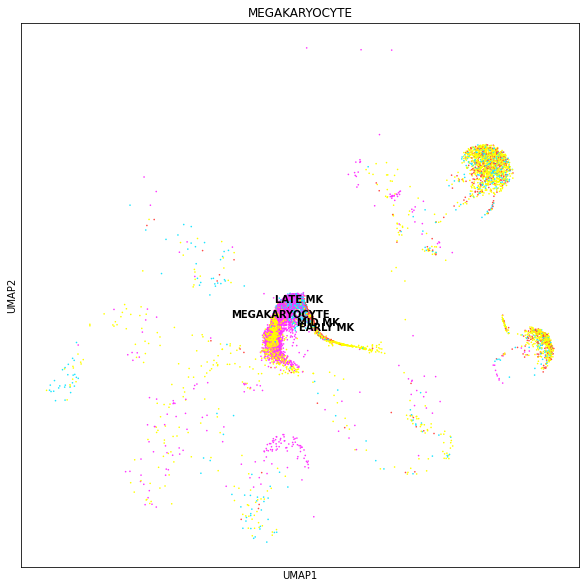

Trying to set attribute `.uns` of view, copying.


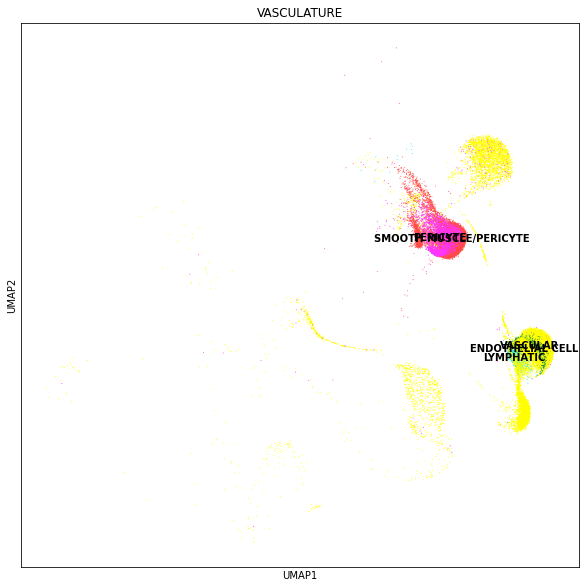

Trying to set attribute `.uns` of view, copying.


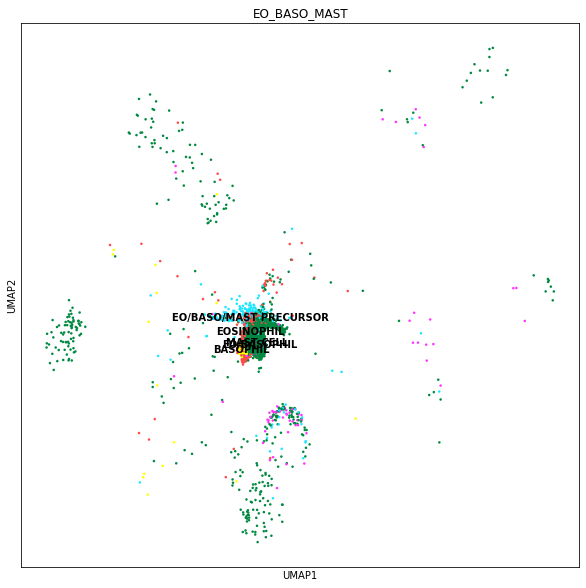

Trying to set attribute `.uns` of view, copying.


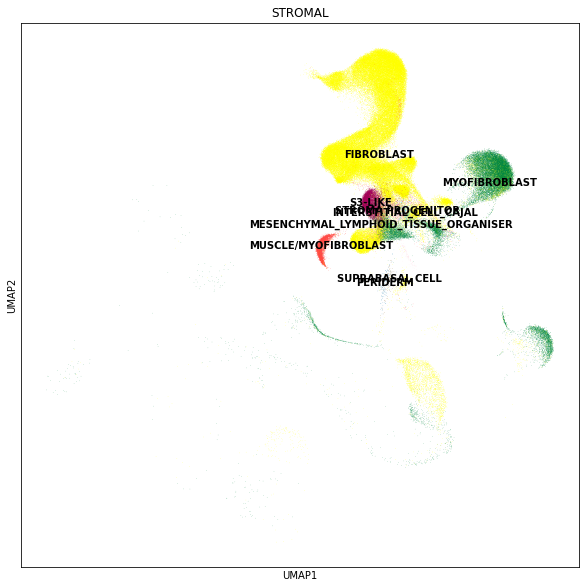

Trying to set attribute `.uns` of view, copying.


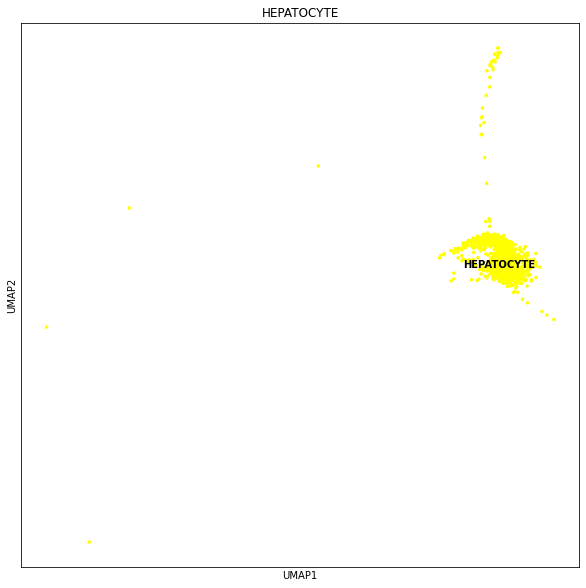

Trying to set attribute `.uns` of view, copying.


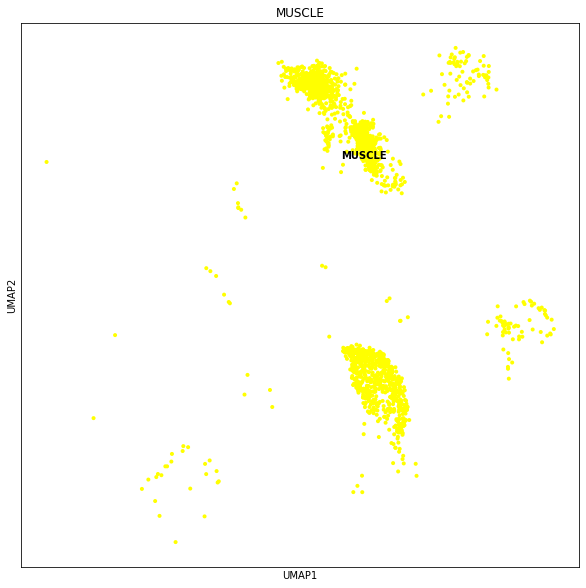

Trying to set attribute `.uns` of view, copying.


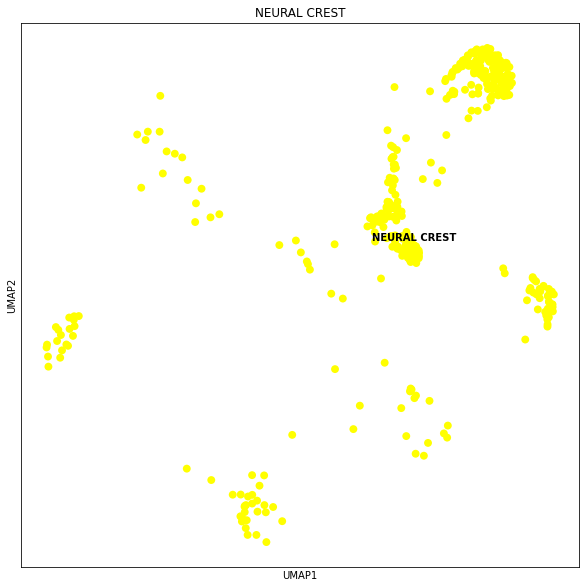

Trying to set attribute `.uns` of view, copying.


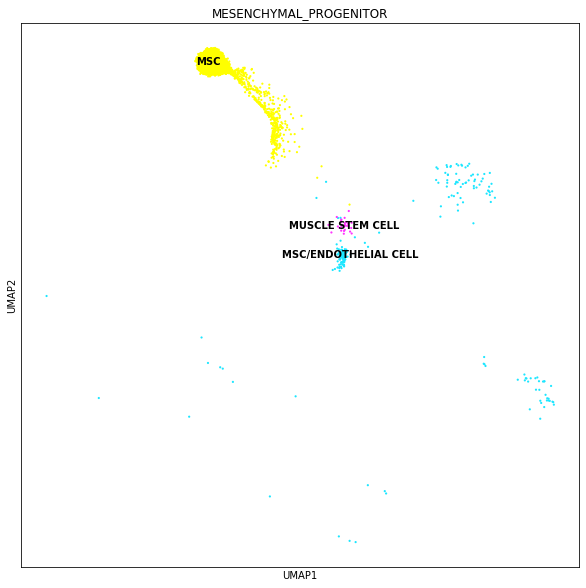

Trying to set attribute `.uns` of view, copying.


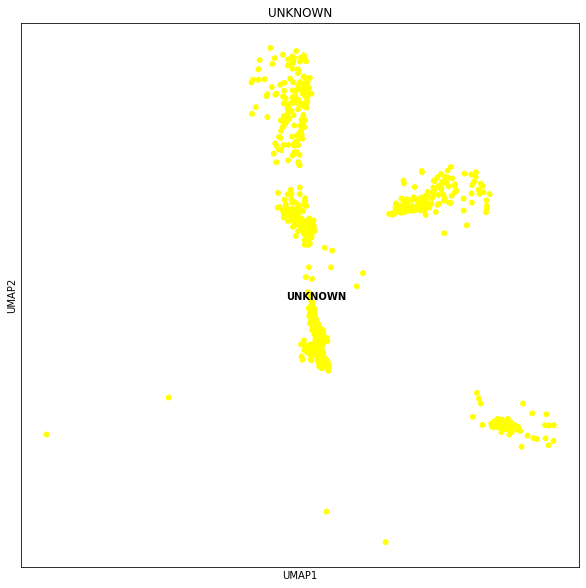

Trying to set attribute `.uns` of view, copying.


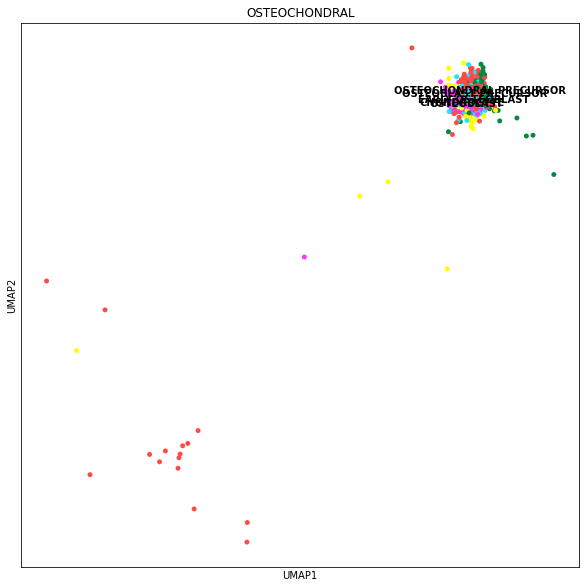

Trying to set attribute `.uns` of view, copying.


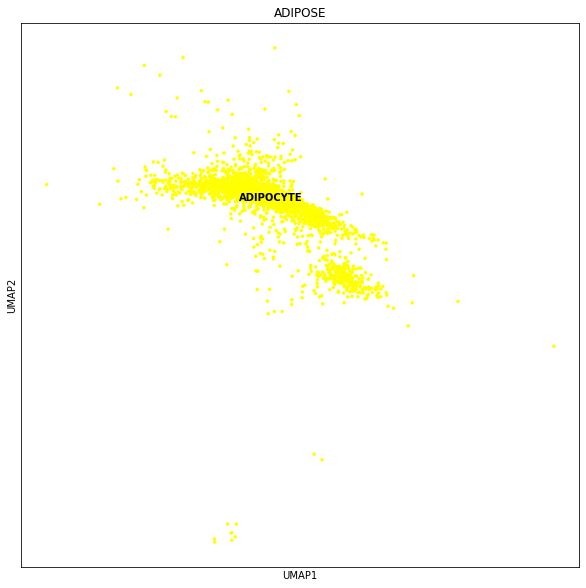

Trying to set attribute `.uns` of view, copying.


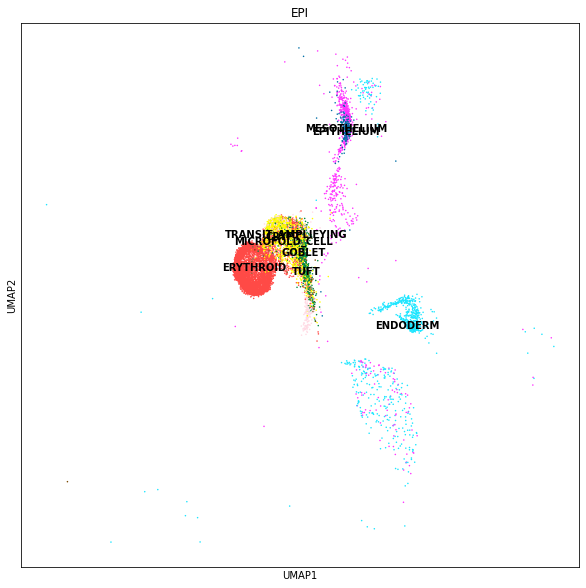

Trying to set attribute `.uns` of view, copying.


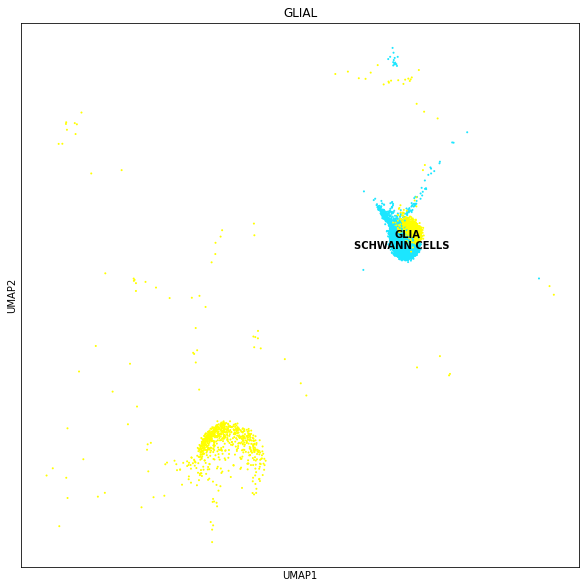

Trying to set attribute `.uns` of view, copying.


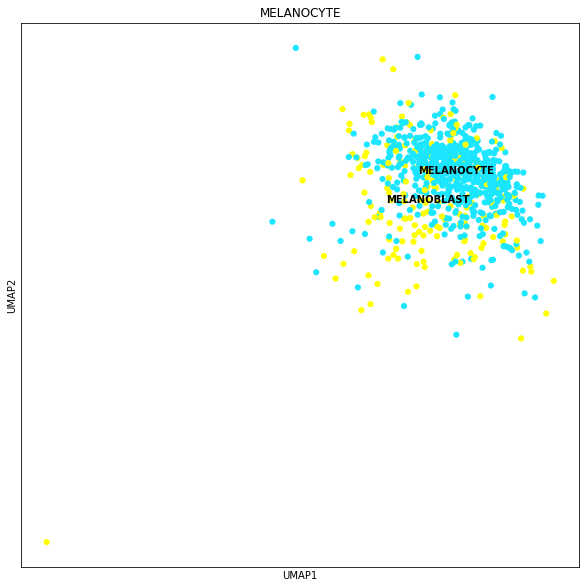

Trying to set attribute `.uns` of view, copying.


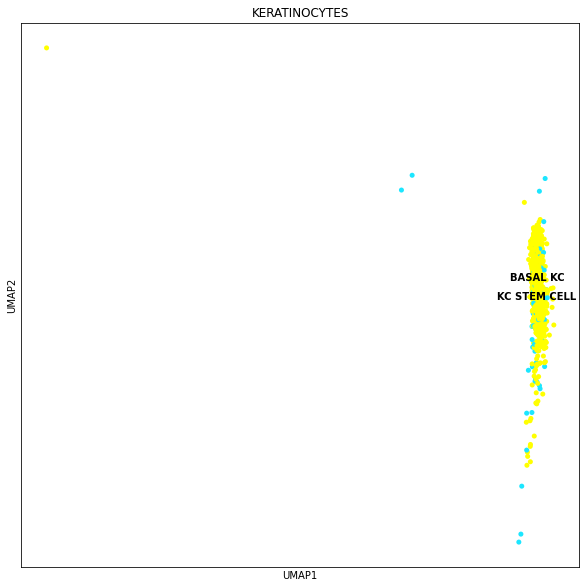

Trying to set attribute `.uns` of view, copying.


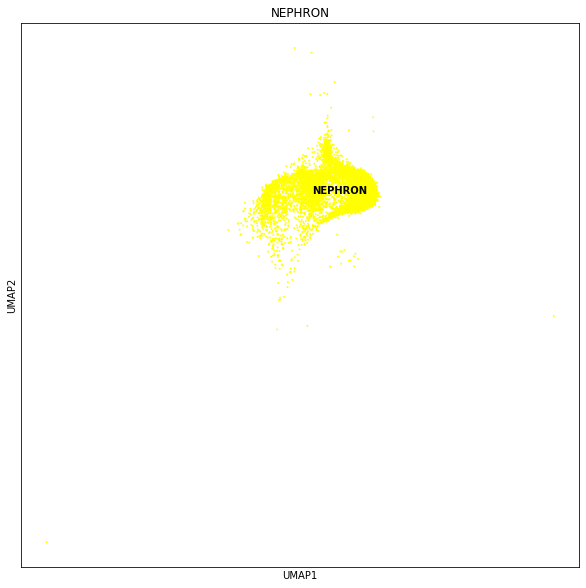

Trying to set attribute `.uns` of view, copying.


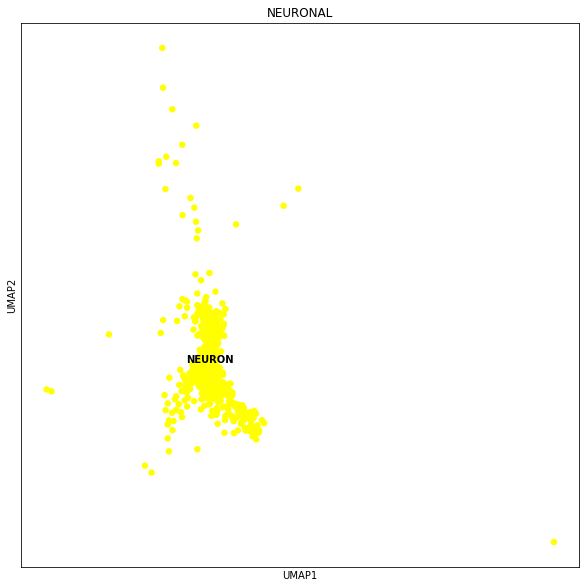

Trying to set attribute `.uns` of view, copying.


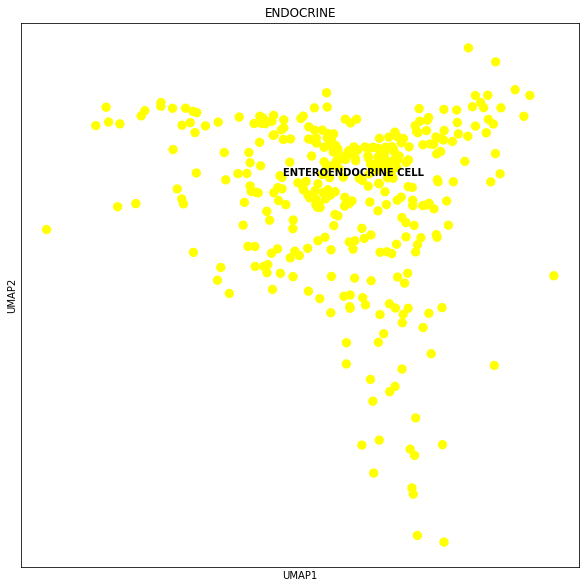

In [85]:
i=1
for lab in merged_pp.obs['uniform_label_lvl0'].unique():
    subset_organ_adata = merged_pp[merged_pp.obs['uniform_label_lvl0']==lab]
    sc.pl.umap(subset_organ_adata, color="uniform_label_expanded_merged", palette=sc.plotting.palettes.default_102,
               legend_loc="on data",
               groups=subset_organ_adata[subset_organ_adata.obs["uniform_label_expanded_merged"] != "nan"].obs["uniform_label_expanded_merged"].unique(),
               title=lab
              )
    i += 1

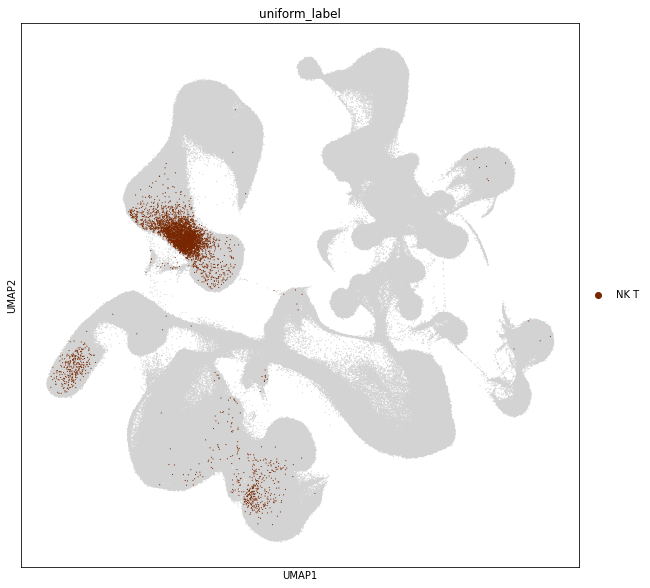

In [118]:
sc.pl.umap(merged_pp, color="uniform_label", groups=["NK T"], size=5)

### Doublet removal

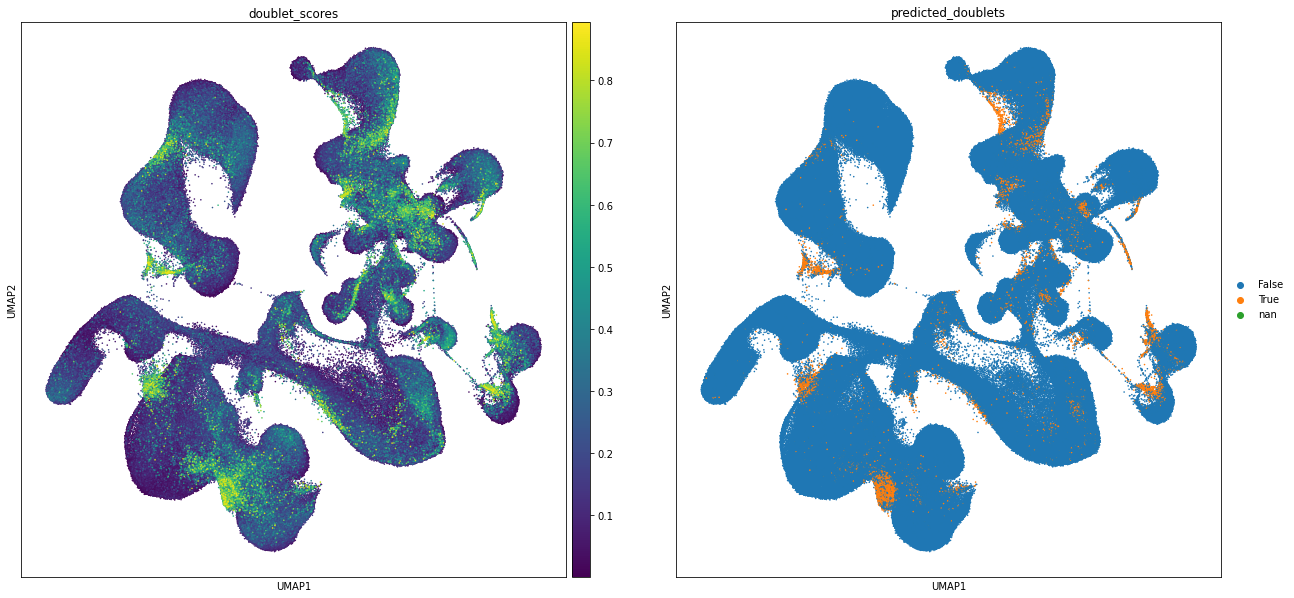

In [114]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_pp, color=['doublet_scores',"predicted_doublets"], size=10)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


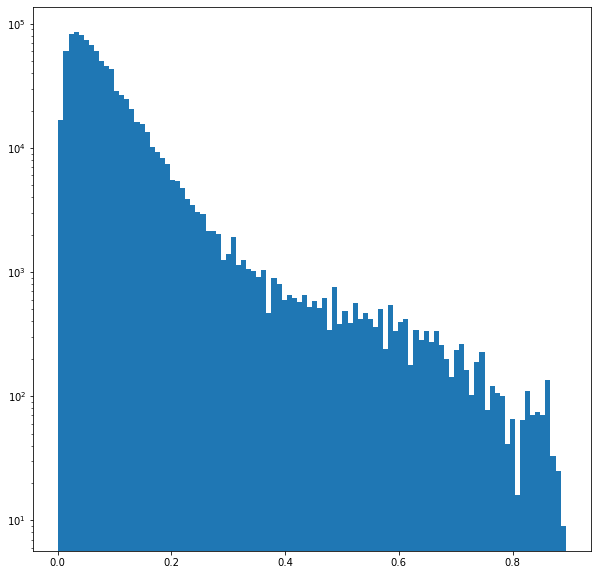

In [95]:
plt.hist(merged_pp.obs['doublet_scores'], bins=100);
plt.yscale('log', nonposy='clip');

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


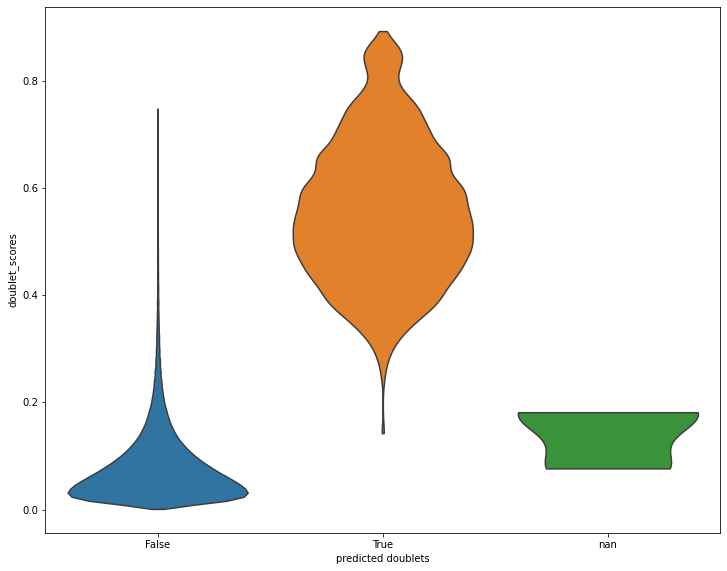

In [111]:
sc.pl.violin(merged_pp, 'doublet_scores',stripplot=False, groupby='predicted_doublets', jitter=False)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


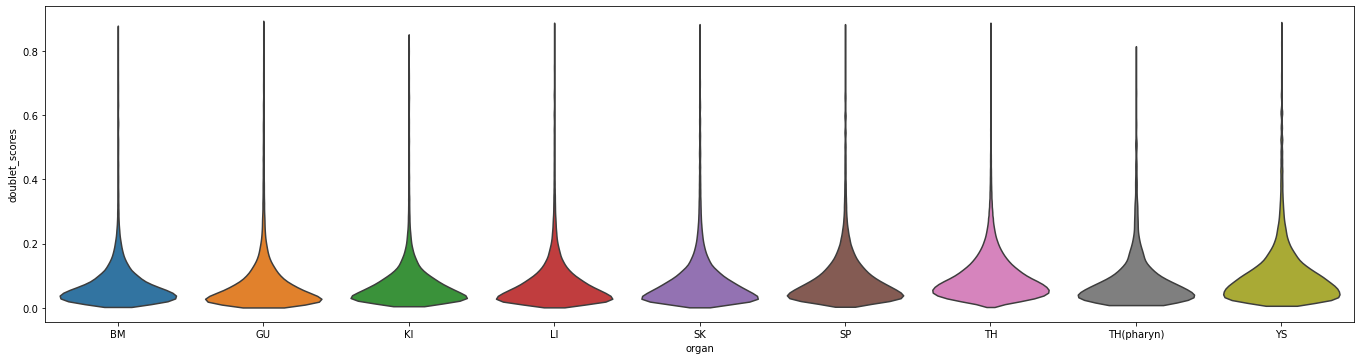

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


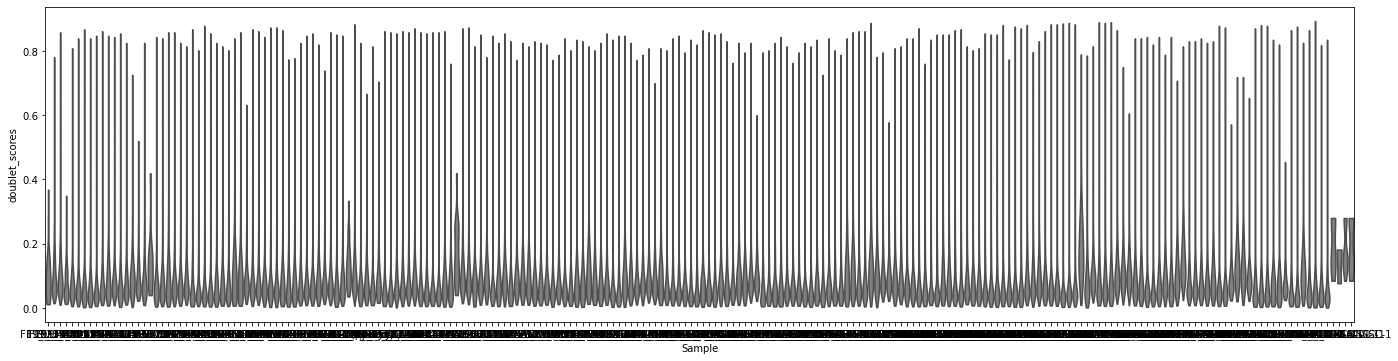

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


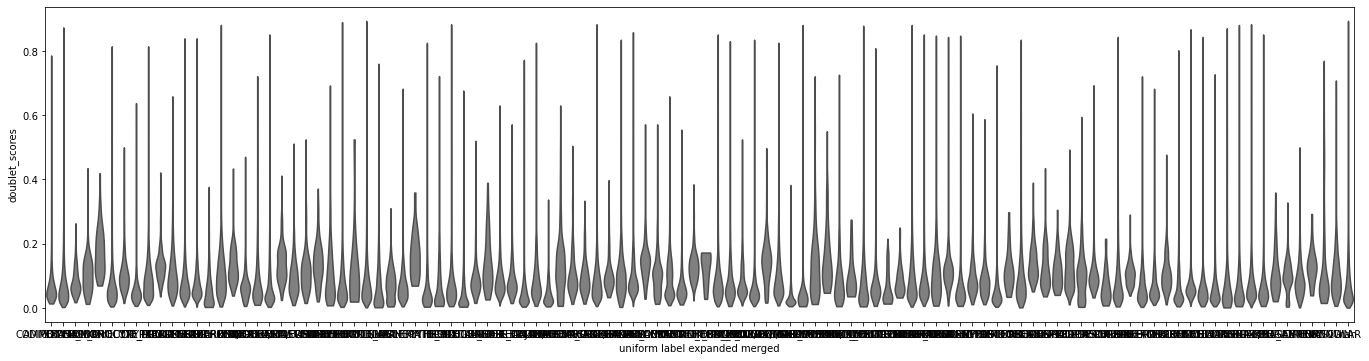

In [107]:
plt.rcParams["figure.figsize"] = [18,6]
sc.pl.violin(merged_pp, 'doublet_scores',stripplot=False, groupby='organ', jitter=False)
sc.pl.violin(merged_pp, 'doublet_scores',stripplot=False, groupby='Sample', jitter=False)
sc.pl.violin(merged_pp, 'doublet_scores',stripplot=False, groupby='uniform_label_expanded_merged', jitter=False)

---